# Επίδοση εργασία 2 - ΟΜΑΔΑ 44
Νικόλαος Μπλέτσας (03118899)

Γεώργιος Τζουμανέκας (03118095)

## Εισαγωγή

In [ ]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

Εισάγουμε τα δεδομένα της εκφώνησης

In [ ]:
# cpu arrival rates (jobs / sec)
cpu_arrival_rate = 0.9

# average service times (sec)
cpu_average_service_time = 54e-3

disk_average_service_time = 35e-3

# average disk visits
average_disk_visits = 18

# average result transfer time (sec)
average_res_trans_time = 234e-3

Το disk_arrival_rate είναι ο ρυθμός με τον οποίο μια εργασία μεταβαίνει από τη CPU στο δίσκο

In [ ]:
# disk arrival rates (jobs / sec)
disk_arrival_rate = average_disk_visits / cpu_average_service_time

Ορίζουμε την κλάση Job για να διευκολύνουμε την προσομοίωση

In [ ]:
class Job:
    def __init__(self, time):
        self.start_time = time
        self.end_time = None
        self.cpu_waiting_time = 0
        self.disk_visits = 0
        self.remaining_time = np.random.exponential(scale=cpu_average_service_time)
        self.disk_remaining_time = None
        self.transfer_time = np.random.exponential(scale=average_res_trans_time)
        self.movement = False
        self.cpu_service_time = 0
            
    def move_to_disk(self):
        self.disk_visits += 1
        self.disk_remaining_time = np.random.exponential(scale=disk_average_service_time)

Η παρακάτω συναρτηση εισάγει μια εργασία σε μία ουρά.

In [ ]:
def insert(job, queue):
    if not queue:
        queue = [job]
        return queue
    else:
        queue.append(job)
        return queue

**Η προσομοίωση γίνεται ως εξής:**

Χωρίζουμε το χρόνο σε πολύ μικρά διαστήματα ώστε να έχουμε

P[άφιξης στο διάστημα dt] = ρυθμός αφίξεων * dt

Και έπειτα προχωράμε το χρόνο κατά dt σε κάθε επανάληψη της προσομοίωσης. Όταν έρχεται μια νέα εργασία, την προσθέτουμε στην ουρά της CPU με υπολειπόμενο χρόνο (πεδίο remaining_time στο Job) δείγμα από εκθετική κατανομή με μέσο όρο τον μέσο χρόνο ανά επίσκεψη στη cpu.

Επίσης υπολογίζουμε την πιθανότητα στο διάστημα dt η εργασία να μεταβεί από τη CPU στο δίσκο.

P[μετάβασης από τη CPU στο δίσκο στο διάστημα dt] = (Μέσος αριθμός επισκέψεων στο δίσκο)*dt/(Μέσος χρόνος εξυπηρέτησης στη CPU)

Αυτό ισχύει για αρκούντως μικρό dt.

Τα σημεία αναγεννησης ορίζονται ως οι στιγμές που μια νέα εργασία εισέρχεται σε άδειο σύστημα (CPU και disk).

## 1η περίπτωση - FIFO

In [ ]:
t = 0
np.random.seed(54)
random.seed(54)
CPU_queue = []
disk_queue = []
completed_jobs = []
cpu_history = []
disk_history = []
regeneration_points = []
max_regeneration_cycles = 1000
confidence_level = 0.95
dt = 1e-3

while len(regeneration_points) < max_regeneration_cycles:
    if CPU_queue:
        # if there are jobs in the cpu queue, process the one with the highest priority
        CPU_queue[0].remaining_time -= dt
        if CPU_queue[0].remaining_time <= 0:
            # if it's done, keep it in the completed list and remove it from the queue
            CPU_queue[0].end_time = t
            completed_jobs.append(CPU_queue[0])
            CPU_queue.pop(0)
        elif random.random() < disk_arrival_rate * dt:
            # jobs move to disk
            CPU_queue[0].move_to_disk()
            disk_queue.append(CPU_queue[0])
            CPU_queue.pop(0)

    # disk
    if disk_queue:
        # if the disk is not empty, process the job with the highest priority
        disk_queue[0].disk_remaining_time -= dt
        if disk_queue[0].disk_remaining_time <= 0:
            # if the job with the highest priority is done move it back to the cpu
            CPU_queue = insert(disk_queue[0], CPU_queue)
            disk_queue.pop(0)
    
    # new arrivals
    if random.random() < cpu_arrival_rate * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(time=t), CPU_queue)

    
    if len(regeneration_points) % 20 == 0 and len(regeneration_points) > 0:
        response_times_B = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
        # ci = confidence interval length
        ci = 2 * confidence_level * np.std(response_times_B) / np.sqrt(len(response_times_B))
        if ci < 0.1 * np.mean(response_times_B):
            break
    
    cpu_history.append(len(CPU_queue))
    disk_history.append(len(disk_queue))
    t += dt

### Αποτελέσματα προσομοίωσης

In [ ]:
response_times = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
print('Average response time:', sum(response_times) / len(response_times))
print('=============================================')
print('Number of completed jobs:', len(completed_jobs))
print('=============================================')
print('CPU Utilization =', len(list(filter(lambda x: x != 0, cpu_history))) / len(cpu_history))
print('Disk Utilization =', len(list(filter(lambda x: x != 0, disk_history))) / len(disk_history))
print('=============================================')
print('Total regeneration cycles:', len(regeneration_points))

Average response time: 1.659979061468609
Number of completed jobs: 504
CPU Utilization = 0.04915853551768067
Disk Utilization = 0.557612488587208
Total regeneration cycles: 220


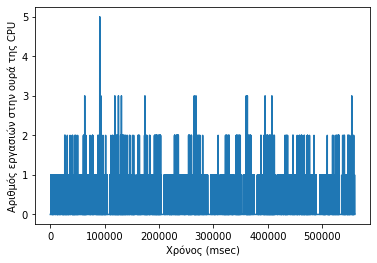

In [ ]:
plt.plot(cpu_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά της CPU')
plt.show()

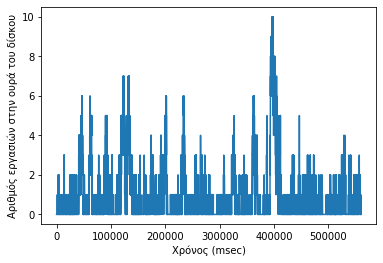

In [ ]:
plt.plot(disk_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά του δίσκου')
plt.show()

## 2η περίπτωση - LWTF

In [ ]:
t = 0
np.random.seed(54)
random.seed(54)
CPU_queue = []
disk_queue = []
completed_jobs = []
cpu_history = []
disk_history = []
regeneration_points = []
max_regeneration_cycles = 1000
confidence_level = 0.95
dt = 1e-3

while len(regeneration_points) < max_regeneration_cycles:
    if CPU_queue:
        i = res = 0
        max = 0
        for x in CPU_queue:
            if x.cpu_waiting_time > max:
                max = x.cpu_waiting_time
                res = i
            i += 1
        # if there are jobs in the cpu queue, process the one with the highest priority
        CPU_queue[res].remaining_time -= dt
        if CPU_queue[res].remaining_time <= 0:
            # if it's done, keep it in the completed list and remove it from the queue
            CPU_queue[res].end_time = t
            completed_jobs.append(CPU_queue[res])
            CPU_queue.pop(res)
        elif random.random() < disk_arrival_rate * dt:
            # jobs move to disk
            CPU_queue[res].move_to_disk()
            disk_queue.append(CPU_queue[res])
            CPU_queue.pop(res)

    # disk
    if disk_queue:
        # if the disk is not empty, process the job with the highest priority
        disk_queue[0].disk_remaining_time -= dt
        if disk_queue[0].disk_remaining_time <= 0:
            # if the job with the highest priority is done move it back to the cpu
            CPU_queue = insert(disk_queue[0], CPU_queue)
            disk_queue.pop(0)
    
    # new arrivals
    if random.random() < cpu_arrival_rate * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(time=t), CPU_queue)

    
    if len(regeneration_points) % 20 == 0 and len(regeneration_points) > 0:
        response_times_B = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
        # ci = confidence interval length
        ci = 2 * confidence_level * np.std(response_times_B) / np.sqrt(len(response_times_B))
        if ci < 0.1 * np.mean(response_times_B):
            break
    
    for i in range (0,len(CPU_queue)):
        CPU_queue[i].cpu_waiting_time += dt

    cpu_history.append(len(CPU_queue))
    disk_history.append(len(disk_queue))
    t += dt

### Αποτελέσματα προσομοίωσης

In [ ]:
response_times = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
print('Average response time:', sum(response_times) / len(response_times))
print('=============================================')
print('Number of completed jobs:', len(completed_jobs))
print('=============================================')
print('CPU Utilization =', len(list(filter(lambda x: x != 0, cpu_history))) / len(cpu_history))
print('Disk Utilization =', len(list(filter(lambda x: x != 0, disk_history))) / len(disk_history))
print('=============================================')
print('Total regeneration cycles:', len(regeneration_points))

Average response time: 1.5759320526482623
Number of completed jobs: 443
CPU Utilization = 0.04529233927554711
Disk Utilization = 0.5109501928613243
Total regeneration cycles: 200


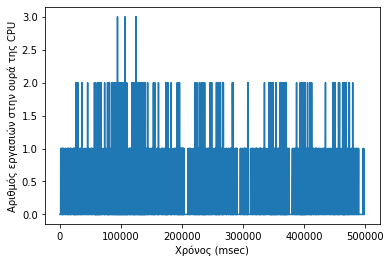

In [ ]:
plt.plot(cpu_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά της CPU')
plt.show()

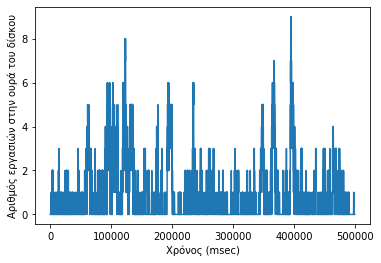

In [ ]:
plt.plot(disk_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά του δίσκου')
plt.show()

## 3η πρίπτωση - LRUF

In [ ]:
t = 0
np.random.seed(54)
random.seed(54)
CPU_queue = []
disk_queue = []
completed_jobs = []
cpu_history = []
disk_history = []
regeneration_points = []
max_regeneration_cycles = 1000
confidence_level = 0.95
dt = 1e-3

while len(regeneration_points) < max_regeneration_cycles:
    if CPU_queue:
        #find the job with the lease cpu service time
        i = x = res = 0
        min = 1000000
        for x in CPU_queue:
            if x.cpu_service_time < min:
                min = x.cpu_service_time
                res = i
            i += 1
        # if there are jobs in the cpu queue, process the one with the highest priority
        CPU_queue[res].remaining_time -= dt
        if (CPU_queue[res].movement == True):
            CPU_queue[res].movement = False
            CPU_queue[res].cpu_service_time = dt
        else:
            CPU_queue[res].cpu_service_time += dt
        CPU_queue[res].time_since_last_cpu_use = 0 #if the job is used in the CPU it's now the least recently used
        if CPU_queue[res].remaining_time <= 0:
            # if it's done, keep it in the completed list and remove it from the queue
            CPU_queue[res].end_time = t
            completed_jobs.append(CPU_queue[res])
            CPU_queue.pop(res)
        elif random.random() < disk_arrival_rate * dt:
            # if a movement is needed then change the boolean
            # jobs move to disk
            CPU_queue[res].movement = True
            CPU_queue[res].move_to_disk()
            disk_queue.append(CPU_queue[res])
            CPU_queue.pop(res)

    # disk
    if disk_queue:
        # if the disk is not empty, process the job with the highest priority
        disk_queue[0].disk_remaining_time -= dt
        if disk_queue[0].disk_remaining_time <= 0:
            # if the job with the highest priority is done move it back to the cpu
            CPU_queue = insert(disk_queue[0], CPU_queue)
            disk_queue.pop(0)
    
    # new arrivals
    if random.random() < cpu_arrival_rate * dt:
        if CPU_queue == [] and disk_queue == []:
            regeneration_points.append(t)
        CPU_queue = insert(Job(time=t), CPU_queue)

    
    if len(regeneration_points) % 20 == 0 and len(regeneration_points) > 0:
        response_times_B = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
        # ci = confidence interval length
        ci = 2 * confidence_level * np.std(response_times_B) / np.sqrt(len(response_times_B))
        if ci < 0.1 * np.mean(response_times_B):
            break

    cpu_history.append(len(CPU_queue))
    disk_history.append(len(disk_queue))
    t += dt

### Αποτελέσματα προσομοίωσης

In [ ]:
response_times = [job.end_time - job.start_time + job.transfer_time for job in completed_jobs]
print('Average response time:', sum(response_times) / len(response_times))
print('=============================================')
print('Number of completed jobs:', len(completed_jobs))
print('=============================================')
print('CPU Utilization =', len(list(filter(lambda x: x != 0, cpu_history))) / len(cpu_history))
print('Disk Utilization =', len(list(filter(lambda x: x != 0, disk_history))) / len(disk_history))
print('=============================================')
print('Total regeneration cycles:', len(regeneration_points))

Average response time: 1.5777831256171666
Number of completed jobs: 444
CPU Utilization = 0.04928031377579338
Disk Utilization = 0.5541398917078826
Total regeneration cycles: 200


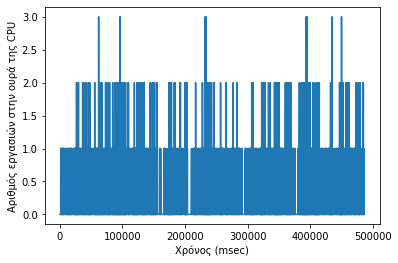

In [ ]:
plt.plot(cpu_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά της CPU')
plt.show()

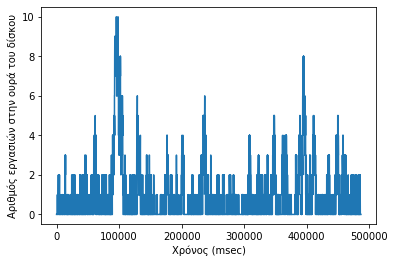

In [ ]:
plt.plot(disk_history)
plt.xlabel('Χρόνος (msec)')
plt.ylabel('Αριθμός εργασιών στην ουρά του δίσκου')
plt.show()